In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import os
import random
import numpy as np

In [2]:
!conda install -y gdown
# https://drive.google.com/file/d/13vbSVWSeZkOAdP_bIxYhOSWtWSpyWBD0/view?usp=share_link
!gdown --id 13vbSVWSeZkOAdP_bIxYhOSWtWSpyWBD0

Retrieving notices: ...working... done
/ - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | 

In [3]:
! unzip folder.zip

Archive:  folder.zip
   creating: lora-nonlora/
   creating: lora-nonlora/valid/
   creating: lora-nonlora/valid/Lora/
  inflating: lora-nonlora/valid/Lora/1642L.png  
  inflating: lora-nonlora/valid/Lora/1602L.png  
  inflating: lora-nonlora/valid/Lora/35L.png  
  inflating: lora-nonlora/valid/Lora/1627L.png  
  inflating: lora-nonlora/valid/Lora/59L.png  
  inflating: lora-nonlora/valid/Lora/1641L.png  
  inflating: lora-nonlora/valid/Lora/1594L.png  
  inflating: lora-nonlora/valid/Lora/1610L.png  
  inflating: lora-nonlora/valid/Lora/1609L.png  
  inflating: lora-nonlora/valid/Lora/1601L.png  
  inflating: lora-nonlora/valid/Lora/1618L.png  
  inflating: lora-nonlora/valid/Lora/1593L.png  
  inflating: lora-nonlora/valid/Lora/1603L.png  
  inflating: lora-nonlora/valid/Lora/1617L.png  
  inflating: lora-nonlora/valid/Lora/1611L.png  
  inflating: lora-nonlora/valid/Lora/1595L.png  
  inflating: lora-nonlora/valid/Lora/1625L.png  
  inflating: lora-nonlora/valid/Lora/1626L.png  
  i

In [4]:
! ls

__notebook__.ipynb  folder.zip	lora-nonlora


In [5]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [6]:
train_transforms = transforms.Compose([
                           transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(10),
                           transforms.RandomCrop((224, 224), pad_if_needed=True),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                       ])

test_transforms = transforms.Compose([
                           transforms.CenterCrop((224, 224)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))
                       ])

In [7]:
train_data = datasets.ImageFolder('/kaggle/working/lora-nonlora/train', train_transforms)
valid_data = datasets.ImageFolder('/kaggle/working/lora-nonlora/valid', test_transforms)
test_data = datasets.ImageFolder('/kaggle/working/lora-nonlora/test', test_transforms)

#import os

#print(len(os.listdir('data/dogs-vs-cats/train')))

#n_train_examples = int(len(train_data)*0.9)
#n_valid_examples = n_test_examples = len(train_data) - n_train_examples

#train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])
#train_data, test_data = torch.utils.data.random_split(train_data, [n_train_examples-n_valid_examples, n_test_examples])

https://github.com/facebook/fb.resnet.torch/issues/180
https://github.com/bamos/densenet.pytorch/blob/master/compute-cifar10-mean.py

In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 3156
Number of validation examples: 80
Number of testing examples: 1000


In [9]:
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
# print(train_data)
# for data, label in train_iterator:
#     print(data)
#     print(label)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

https://discuss.pytorch.org/t/why-does-the-resnet-model-given-by-pytorch-omit-biases-from-the-convolutional-layer/10990/4
https://github.com/kuangliu/pytorch-cifar/blob/master/models/resnet.py

In [10]:
import torch
print(torch.cuda.is_available())


True


In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [12]:
import torchvision.models as models

model = models.resnet18().to(device)

In [13]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
for param in model.parameters():
    param.requires_grad = False

In [15]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [16]:
model.fc = nn.Linear(in_features=512, out_features=2).to(device)

In [17]:
optimizer = optim.Adam(model.parameters())

In [18]:
criterion = nn.CrossEntropyLoss()

In [19]:
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [20]:
def train(model, device, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        fx = model(x)
        loss = criterion(fx, y)
        
        acc = calculate_accuracy(fx, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [21]:
def evaluate(model, device, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            fx = model(x)
            # print(x)
            # print(fx)

            loss = criterion(fx, y)

            acc = calculate_accuracy(fx, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [22]:
import os
EPOCHS = 10
SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'resnet-lora.pt')

best_valid_loss = float('inf')
best_valid_acc = 0.0

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, device, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, device, valid_iterator, criterion)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_acc = valid_acc

        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')



| Epoch: 01 | Train Loss: 0.319 | Train Acc: 87.99% | Val. Loss: 0.326 | Val. Acc: 96.88% |
| Epoch: 02 | Train Loss: 0.257 | Train Acc: 90.99% | Val. Loss: 0.382 | Val. Acc: 84.38% |
| Epoch: 03 | Train Loss: 0.235 | Train Acc: 91.99% | Val. Loss: 0.220 | Val. Acc: 96.88% |
| Epoch: 04 | Train Loss: 0.224 | Train Acc: 91.99% | Val. Loss: 0.182 | Val. Acc: 96.88% |
| Epoch: 05 | Train Loss: 0.222 | Train Acc: 91.98% | Val. Loss: 0.191 | Val. Acc: 96.88% |
| Epoch: 06 | Train Loss: 0.225 | Train Acc: 91.98% | Val. Loss: 0.177 | Val. Acc: 96.88% |
| Epoch: 07 | Train Loss: 0.214 | Train Acc: 92.48% | Val. Loss: 0.164 | Val. Acc: 96.88% |
| Epoch: 08 | Train Loss: 0.208 | Train Acc: 92.46% | Val. Loss: 0.153 | Val. Acc: 96.88% |
| Epoch: 09 | Train Loss: 0.213 | Train Acc: 92.29% | Val. Loss: 0.154 | Val. Acc: 96.88% |
| Epoch: 10 | Train Loss: 0.215 | Train Acc: 91.49% | Val. Loss: 0.144 | Val. Acc: 96.88% |


In [23]:
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

test_loss, test_acc = evaluate(model, device, valid_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:05.2f}% |')

| Test Loss: 0.144 | Test Acc: 96.88% |


Training Loss: 0.196 | Training Accuracy: 92.96%
Test Loss: 0.375 | Test Accuracy: 89.47%


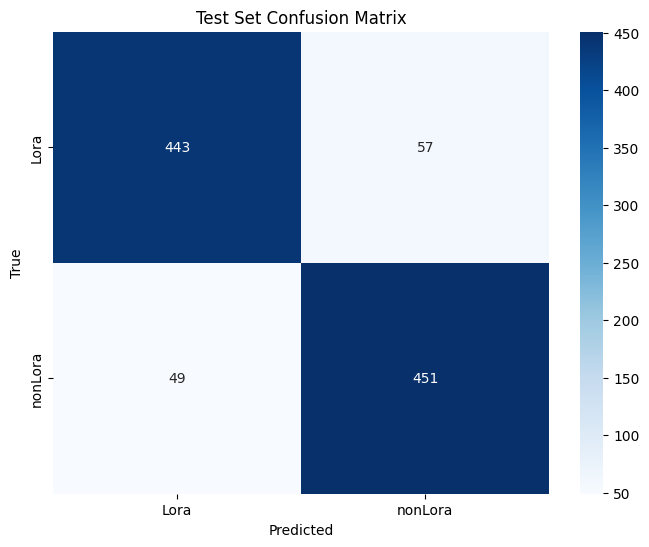

In [24]:

train_true_labels = []
train_predicted_labels = []
test_true_labels = []
test_predicted_labels = []

model.eval()

train_loss, train_acc = evaluate(model, device, train_iterator, criterion)
print(f'Training Loss: {train_loss:.3f} | Training Accuracy: {train_acc * 100:.2f}%')


for (x, y) in train_iterator:
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        fx = model(x)


    predicted_class = fx.argmax(1)
    
   
    train_true_labels.extend(y.cpu().numpy())
    train_predicted_labels.extend(predicted_class.cpu().numpy())

test_loss, test_acc = evaluate(model, device, test_iterator, criterion)
print(f'Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc * 100:.2f}%')

for (x, y) in test_iterator:
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        fx = model(x)

 
    predicted_class = fx.argmax(1)
    
    
    test_true_labels.extend(y.cpu().numpy())
    test_predicted_labels.extend(predicted_class.cpu().numpy())


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


test_confusion = confusion_matrix(test_true_labels, test_predicted_labels)


classes = ['Lora', 'nonLora']  
plt.figure(figsize=(8, 6))
sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Set Confusion Matrix')
plt.show()


In [25]:
# calculate false positives
false_positives = test_confusion.sum(axis=0) - np.diag(test_confusion)

# calculate false negatives
false_negatives = test_confusion.sum(axis=1) - np.diag(test_confusion)
# calculate false positive rate
false_positive_rate = false_positives.sum() / (false_positives.sum() + np.diag(test_confusion).sum())

# calculate false negative rate
false_negative_rate = false_negatives.sum() / (false_negatives.sum() + np.diag(test_confusion).sum())
print(false_positive_rate,false_negative_rate)

0.106 0.106


In [26]:
from PIL import Image
import torch

# Load and preprocess the image
image_path = '/kaggle/working/lora-nonlora/test/nonLora/0_2487N.png'
image = Image.open(image_path)

# Apply the same preprocessing transformations used for the dataset
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
preprocessed_image = image_transforms(image).unsqueeze(0)  # Add batch dimension

# Ensure the model is in evaluation mode
model.eval()

# Move the preprocessed image to the same device used for training (CPU or GPU)
preprocessed_image = preprocessed_image.to(device)

# Pass the image through the model
with torch.no_grad():
    output = model(preprocessed_image)

# Get the predicted class (assuming you have 2 classes)
predicted_class = output.argmax().item()

# Print the predicted class or use it for further processing
print(f'Predicted class: {predicted_class}')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/lora-nonlora/test/nonLora/0_2487N.png'

In [ ]:
from PIL import Image
import os

# Directory path containing the images you want to classify
image_directory = '/kaggle/working/lora-nonlora/test/nonLora'

# List of image file names in the directory
image_filenames = os.listdir(image_directory)

# Apply the same preprocessing transformations used for the dataset
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Ensure the model is in evaluation mode
model.eval()

# Initialize a list to store predictions
predictions = []

# Loop through each image and get predictions
for filename in image_filenames:
    image_path = os.path.join(image_directory, filename)
    image = Image.open(image_path)
    
    # Preprocess the image
    preprocessed_image = image_transforms(image).unsqueeze(0)  # Add batch dimension

    # Move the preprocessed image to the same device used for training (CPU or GPU)
    preprocessed_image = preprocessed_image.to(device)

    # Pass the image through the model
    with torch.no_grad():
        output = model(preprocessed_image)

    # Get the predicted class (assuming you have 2 classes)
    predicted_class = output.argmax().item()

    # Store the filename and predicted class in the predictions list
    predictions.append((filename, predicted_class))

# Print or process the predictions
for filename, predicted_class in predictions:
    print(f'Image: {filename}, Predicted class: {predicted_class}')


In [ ]:
import torch
import torchvision.models as models


# Load the model

# model_checkpoint = torch.load('C:/Users/Abhijith/Desktop/loramodel/models/resnet-lora.pt')
# model = model_checkpoint['model']
model.eval()
from PIL import Image
import os

# Directory path containing the images you want to classify
image_directory = '/kaggle/working/lora-nonlora/test/Lora'

# List of image file names in the directory
image_filenames = os.listdir(image_directory)

# Apply the same preprocessing transformations used for the dataset
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])
# You can now use the model for inference, e.g., for making predictions
# Make sure to preprocess your input data appropriately before passing it to the model
# Initialize a list to store predictions
predictions = []

# Loop through each image and get predictions
for filename in image_filenames:
    image_path = os.path.join(image_directory, filename)
    image = Image.open(image_path)
    
    # Preprocess the image
    preprocessed_image = image_transforms(image).unsqueeze(0)  # Add batch dimension

    # Move the preprocessed image to the same device used for training (CPU or GPU)
    preprocessed_image = preprocessed_image.to(device)

    # Pass the image through the model
    with torch.no_grad():
        output = model(preprocessed_image)

    # Get the predicted class (assuming you have 2 classes)
    predicted_class = output.argmax().item()

    # Store the filename and predicted class in the predictions list
    predictions.append((filename, predicted_class))

# Print or process the predictions
for filename, predicted_class in predictions:
    print(f'Image: {filename}, Predicted class: {predicted_class}')